### Preamble:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Importing the Dataset:

In [2]:
try:
    df_stock_prices = pd.read_csv(r"C:\Users\IRLXB03\Downloads\bloomberg_data_DL.csv")
except FileNotFoundError:
    df_stock_prices = pd.read_csv(r"C:\Users\belmu\Downloads\bloomberg_data_DL.csv")

In [3]:
# Drop rows with any NaN values:
df_stock_prices = df_stock_prices.dropna()

# Rename columns: 
df_stock_prices = df_stock_prices.rename(columns={
    'AGG US Equity': 'bond_price',
    'VTI US Equity': 'stock_price',
    'DBC US Equity': 'commodity_price',
    'VIX Index': 'volatility_price',
    df_stock_prices.columns[0]: 'date'   # rename first col
})

# Convert to numeric (in case of bad values -> NaN) 
cols = ['stock_price', 'bond_price', 'commodity_price', 'volatility_price']
df_stock_prices[cols] = df_stock_prices[cols].apply(pd.to_numeric, errors='coerce')

# Normalize prices using the initial price:
df_stock_prices[cols] = df_stock_prices[cols] / df_stock_prices[cols].iloc[0]

# Convert date column:
df_stock_prices['date'] = pd.to_datetime(df_stock_prices['date'])

# Reorder by date:
df_stock_prices = df_stock_prices.sort_values('date').reset_index(drop=True)

# Create columns with returns:
for col in cols:
    col_name = f'{col}'.replace('_price', '_return')
    df_stock_prices[col_name] = df_stock_prices[col].pct_change()

# Drop first row (NaN values in returns):
df_stock_prices = df_stock_prices.dropna().reset_index(drop=True)

# Define max and min dates:
max_date = df_stock_prices['date'].max()
min_date = df_stock_prices['date'].min()

# Choose feature columns (prices + returns):
price_cols = ['stock_price', 'bond_price', 'commodity_price', 'volatility_price']
return_cols = ['stock_return', 'bond_return', 'commodity_return', 'volatility_return']
feature_cols = price_cols + return_cols

# Define split dates to match those ones in the paper:
train_end   = pd.Timestamp("2010-12-31")
val_end     = pd.Timestamp("2015-12-31")
test_end    = pd.Timestamp("2020-04-30")

# Training set: 2006-02-06 to 2010-12-31:
df_train = df_stock_prices[df_stock_prices['date'] <= train_end].reset_index(drop=True)

# Validation set: 2011-01-01 to 2015-12-31:
df_val   = df_stock_prices[(df_stock_prices['date'] > train_end) &
                           (df_stock_prices['date'] <= val_end)].reset_index(drop=True)

# Test set: 2016-01-01 to 2020-04-30:
df_test  = df_stock_prices[(df_stock_prices['date'] > val_end) &
                           (df_stock_prices['date'] <= test_end)].reset_index(drop=True)


In [4]:
df_train.head()

,date,stock_price,bond_price,commodity_price,volatility_price,stock_return,bond_return,commodity_return,volatility_return
0,2006-02-06,1.002380,0.999801,0.987758,1.006173,0.002380,-0.000199,-0.012242,0.006173
1,2006-02-07,0.992622,0.999102,0.959184,1.048611,-0.009735,-0.000699,-0.028928,0.042178
2,2006-02-08,0.999762,0.998604,0.955104,0.989969,0.007193,-0.000498,-0.004253,-0.055923
3,2006-02-09,0.997858,0.999202,0.964080,1.012346,-0.001904,0.000599,0.009397,0.022603
4,2006-02-10,0.999905,0.997107,0.946528,0.993056,0.002051,-0.002097,-0.018206,-0.019055


In [5]:
df_val.head()

,date,stock_price,bond_price,commodity_price,volatility_price,stock_return,bond_return,commodity_return,volatility_return
0,2011-01-03,1.149657,1.307067,1.204416,1.358796,0.010320,-0.001134,0.004357,-0.007887
1,2011-01-04,1.147377,1.307438,1.188308,1.341049,-0.001983,0.000284,-0.013374,-0.013061
2,2011-01-05,1.153687,1.301127,1.200934,1.313272,0.005500,-0.004827,0.010625,-0.020713
3,2011-01-06,1.151058,1.301374,1.184827,1.342593,-0.002279,0.000190,-0.013412,0.022327
4,2011-01-07,1.148429,1.305582,1.180474,1.322531,-0.002284,0.003234,-0.003674,-0.014943


In [6]:
df_test.head()

,date,stock_price,bond_price,commodity_price,volatility_price,stock_return,bond_return,commodity_return,volatility_return
0,2016-01-04,1.986531,1.525945,0.577178,1.597222,-0.014957,-0.000370,-0.007486,0.136738
1,2016-01-05,1.990978,1.526652,0.571520,1.492284,0.002239,0.000463,-0.009803,-0.065700
2,2016-01-06,1.964295,1.532447,0.562380,1.588735,-0.013402,0.003796,-0.015992,0.064633
3,2016-01-07,1.916150,1.532306,0.559770,1.928241,-0.024510,-0.000092,-0.004641,0.213696
4,2016-01-08,1.894301,1.535698,0.557155,2.084105,-0.011402,0.002214,-0.004671,0.080832


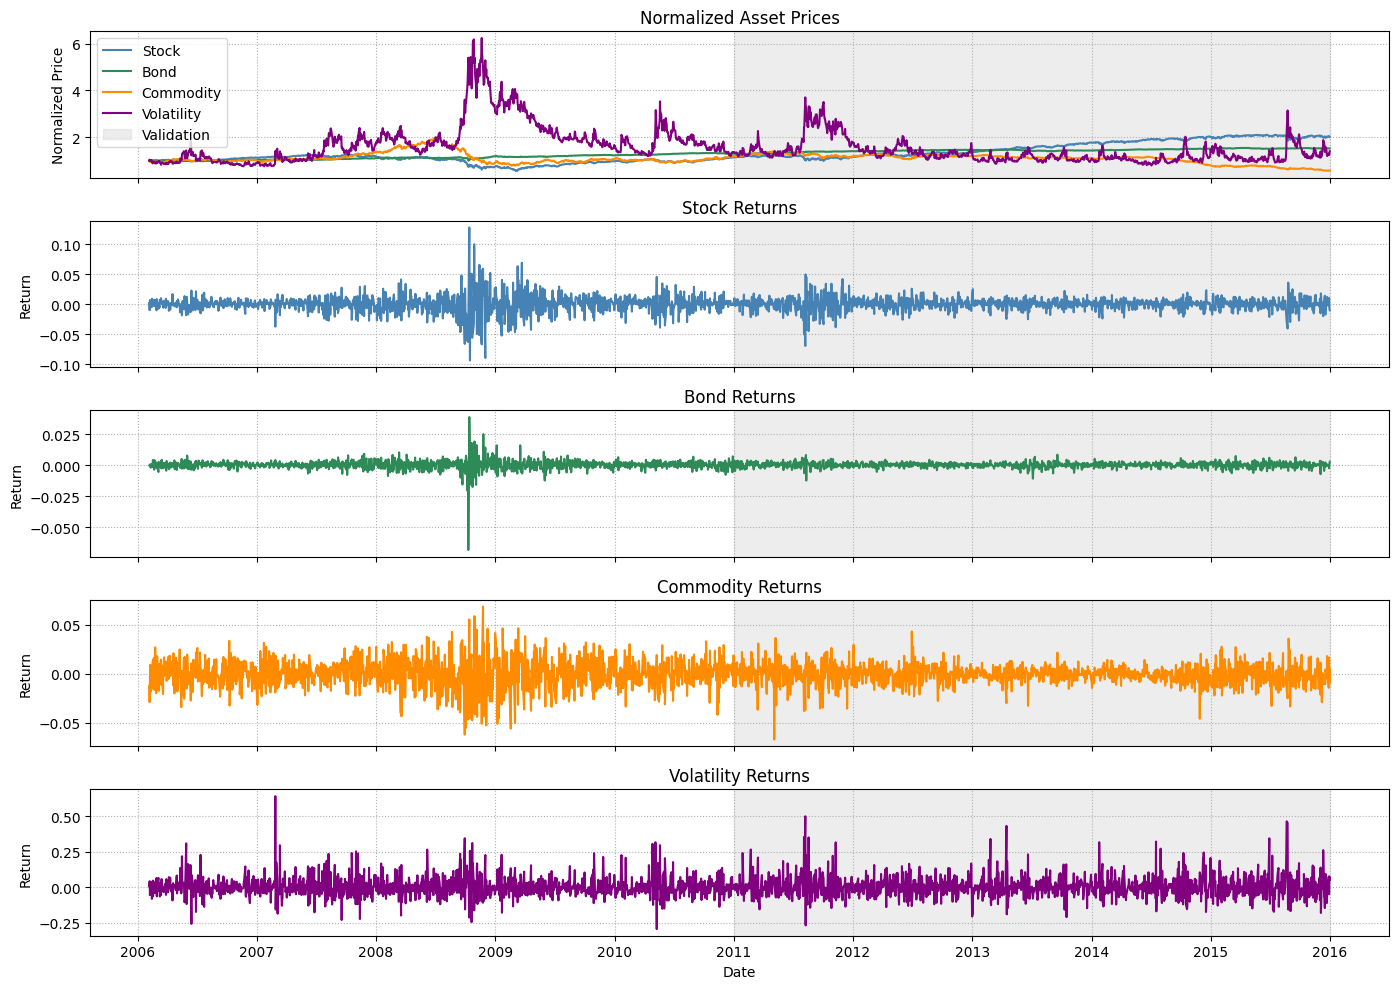

In [7]:
# Define colors per asset
asset_colors = {
    'stock': 'steelblue',
    'bond': 'seagreen',
    'commodity': 'darkorange',
    'volatility': 'purple'
}

# Define columns
price_cols  = ['stock_price', 'bond_price', 'commodity_price', 'volatility_price']
return_cols = ['stock_return', 'bond_return', 'commodity_return', 'volatility_return']

# Validation boundaries
val_start = df_val['date'].min()
val_end   = df_val['date'].max()

# Restrict full dataset up to the end of validation period
mask = df_stock_prices['date'] <= val_end
df_plot = df_stock_prices.loc[mask].reset_index(drop=True)

# Create figure: 1 price plot + 4 return plots
fig, axes = plt.subplots(len(return_cols) + 1, 1, figsize=(14, 10), sharex=True)

# === 1. TOP PANEL: Normalized Prices ===
ax = axes[0]
for col in price_cols:
    asset = col.replace('_price', '')
    color = asset_colors[asset]
    ax.plot(df_plot['date'], df_plot[col], label=asset.capitalize(), color=color)

# Shade validation region
ax.axvspan(val_start, val_end, color='lightgray', alpha=0.4, zorder=0, label='Validation')
ax.set_title('Normalized Asset Prices')
ax.set_ylabel('Normalized Price')
ax.legend()
ax.grid(ls=':')

# === 2. RETURN PANELS ===
for i, col in enumerate(return_cols):
    ax = axes[i + 1]
    asset = col.replace('_return', '')
    color = asset_colors[asset]

    ax.plot(df_plot['date'], df_plot[col], color=color, label=asset.capitalize())
    ax.axvspan(val_start, val_end, color='lightgray', alpha=0.4, zorder=0)

    ax.set_title(f'{asset.capitalize()} Returns')
    ax.set_ylabel('Return')
    ax.grid(ls=':')

# Common x-label and layout
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


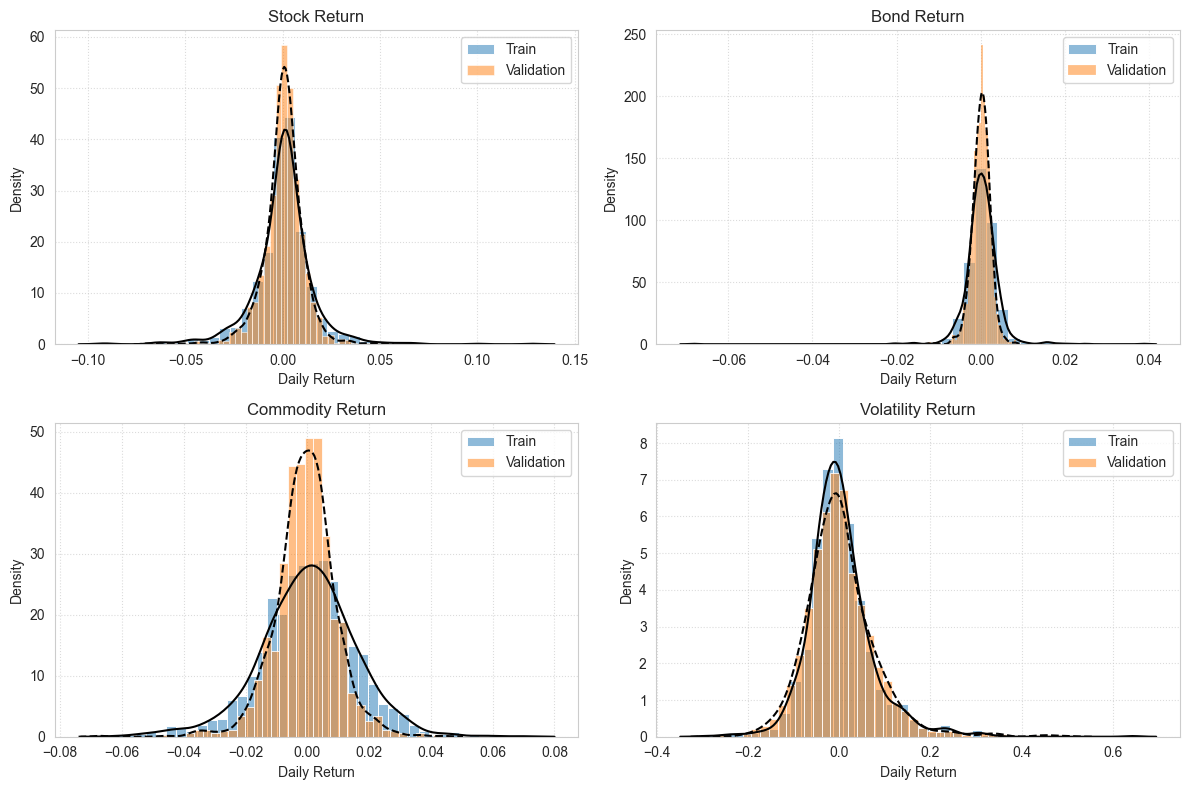

In [8]:
# Configure plot style
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, asset in enumerate(return_cols):
    ax = axes[i]
    
    # Plot histogram for Train
    sns.histplot(df_train[asset], bins=40, color="tab:blue", alpha=0.5,
                 stat="density", label="Train", ax=ax)
    
    # Plot histogram for Validation
    sns.histplot(df_val[asset], bins=40, color="tab:orange", alpha=0.5,
                 stat="density", label="Validation", ax=ax)
    
    # Overlay smoothed density (kernel estimation) in black
    sns.kdeplot(df_train[asset], color="black", lw=1.5, ax=ax)
    sns.kdeplot(df_val[asset], color="black", lw=1.5, ax=ax, ls="--")
    
    ax.set_title(asset.replace("_", " ").title())
    ax.set_xlabel("Daily Return")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(ls=":", alpha=0.7)

# Adjust layout and show
plt.tight_layout()
plt.show()

In [9]:
summary = pd.concat({
    'Train': df_train[return_cols].describe(),
    'Validation': df_val[return_cols].describe()
}, axis=1)

# Reorder columns so each asset shows Train/Validation next to each other
summary = summary.swaplevel(axis=1).sort_index(axis=1)

summary

bond_return              commodity_return              stock_return  \
             Train   Validation            Train   Validation        Train   
count  1236.000000  1258.000000      1236.000000  1258.000000  1236.000000   
mean      0.000227     0.000125         0.000269    -0.000527     0.000227   
std       0.004215     0.002109         0.015620     0.009802     0.015675   
min      -0.068395    -0.012439        -0.062020    -0.066991    -0.093530   
25%      -0.001525    -0.001105        -0.008937    -0.005568    -0.005486   
50%       0.000244     0.000189         0.000834    -0.000351     0.000891   
75%       0.002034     0.001464         0.009697     0.004897     0.006574   
max       0.038687     0.008395         0.068747     0.043354     0.128298   

                   volatility_return               
        Validation             Train   Validation  
count  1258.000000       1236.000000  1258.000000  
mean      0.000504          0.002810     0.002922  
std       0.009932          0.073190     0.078257  
min      -0.069295         -0.295726    -0.269583  
25%      -0.004020         -0.037699    -0.043491  
50%       0.000797         -0.005469    -0.004748  
75%       0.005560          0.032641     0.039028  
max       0.050045          0.642152     0.500000

### Constructing the dataset:

In [10]:
# Hyperparameters:
seq_len = 50                        # Lookback window.
batch_size = 64                     # Batch size for DataLoader.
num_assets = len(return_cols)       # Number of assets to allocate to.
input_dim = len(feature_cols)       # Number of features per date.
hidden_size = 64                    # LSTM hidden size.
num_epochs = 10                     # Number of training epochs.
num_layers = 1                      # Number of one-directional layers in the LSTM.

##### Building (X, Y) Sequences for LSTM Training

For each time index `t` starting at `seq_len`:
1. **Input (`X_t`)** → the previous `seq_len` rows  
   $$
   X_t = [\text{features}_{t-\text{seq\_len}}, \dots, \text{features}_{t-1}]
   $$
   with shape `(seq_len, input_dim)`.
2. **Target (`Y_t`)** → the returns on the following day  
   $$
   Y_t = \text{returns}_t
   $$
   with shape `(num_assets,)`.

Rolling this window across the dataset yields:
$$
X \in \mathbb{R}^{N \times \text{seq\_len} \times \text{input\_dim}}, \quad
Y \in \mathbb{R}^{N \times \text{num\_assets}}
$$

where $N$ represents the number of training samples you end up with after constructing all rolling windows.

In [11]:
def make_xy(df, seq_len, feature_cols, return_cols):
    X, Y = [], []
    for t in range(seq_len, len(df)):
        # Features: last seq_len rows. Note: iloc[t-seq_len:t] includes prices_{t-1} and returns_{t-2->t_1}.
        X.append(df[feature_cols].iloc[t-seq_len:t].values)
        # Label: next-day returns. Note: iloc[t] includes prices_{t} and returns_{t-1->t}.
        Y.append(df[return_cols].iloc[t].values)
    return np.array(X), np.array(Y)

X_train, Y_train = make_xy(df_train, seq_len, feature_cols=feature_cols, return_cols=return_cols)
X_val,   Y_val   = make_xy(df_val,   seq_len, feature_cols=feature_cols, return_cols=return_cols)
X_test,  Y_test  = make_xy(df_test,  seq_len, feature_cols=feature_cols, return_cols=return_cols)

In [12]:
# Convert numpy arrays to torch tensors:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test,  dtype=torch.float32)

# Create TensorDatasets:
train_ds = TensorDataset(X_train_t, Y_train_t)
val_ds   = TensorDataset(X_val_t,   Y_val_t)
test_ds  = TensorDataset(X_test_t,  Y_test_t)

# DataLoader with batching and shuffling
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

### Constructing the Model: LSTM → Dense → Softmax model

In [13]:
class PortfolioNet(nn.Module):
    def __init__(self, input_dim, hidden_size, num_assets, num_layers):
        """
        input_dim   = number of features at each time step (e.g. 8: 4 prices + 4 returns)
        hidden_size = number of hidden units inside the LSTM (e.g. 64)
        num_assets  = number of portfolio weights we want as output (e.g. 4 assets)
        """
        super().__init__()   # initialize the parent nn.Module class

        # Define an LSTM layer
        # batch_first=True means input shape is [batch, seq_len, input_dim]
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        # Define a fully connected (dense) layer: Maps from the hidden_size (e.g. 64)-> number of assets (e.g. 4)
        self.fc = nn.Linear(hidden_size, num_assets)

    def forward(self, x):
        """
        Forward pass: defines how input data flows through the network

        x: [batch, seq_len, input_dim]
        Example: if batch_size=32, seq_len=50, input_dim=8 → shape [32, 50, 8]
        """

        # Pass the input sequence through the LSTM
        _, (h_n, _) = self.lstm(x) 

        # Picks the hidden state from the last layer, last time step 
        h_last = h_n[-1] # Shape becomes [batch, hidden_size]

        # Pass the last hidden state through the fully connected layer
        logits = self.fc(h_last)   #  One logit (raw score) [batch, hidden_size]→[batch, num_assets]

        # Apply softmax so that the outputs become portfolio weights:
        # - Each weight is >= 0
        # - All weights sum to 1
        weights = F.softmax(logits, dim=-1) # -> shape: [batch, num_assets]

        return weights

#### Custom sharpe ratio loss:

In [14]:
def sharpe_loss_batch(weights, next_day_returns):
    '''
    Compute the negative Sharpe ratio for a batch of portfolio weights and realized returns.
    The model is trained to maximize the Sharpe ratio by minimizing this loss.

    Arguments:

    weights: [batch, num_assets]
        - portfolio weights predicted by the model for each example in the batch
        - each row sums to 1 (because of softmax)
        - Example (batch=3, num_assets=4):
          [[0.2, 0.3, 0.1, 0.4],
           [0.1, 0.5, 0.2, 0.2],
           [0.25, 0.25, 0.25, 0.25]]

    next_day_returns: [batch, num_assets]
        - actual realised asset returns for the next day, one row per example
        - Example (same batch=3, num_assets=4):
          [[ 0.01, -0.005, 0.002, 0.003],
           [-0.002, 0.004, 0.001, -0.001],
           [ 0.010, 0.012, -0.003, 0.005]]

    Note:  The loss averages returns across the batch, which may contain non-contiguous dates
    (if DataLoader shuffle=True). This yields an *expected* Sharpe across random windows,
    not the realized time-series Sharpe of a continuous strategy.
    '''
    # Compute daily portfolio returns: R_t = sum_i w_{t-1,i} * r_{t,i}
    port_rets = (weights * next_day_returns).sum(dim=1)  
    # Compute the expected portfolio return and std over this batch:
    mean_R = port_rets.mean()                            
    std_R = port_rets.std(unbiased=False) + 1e-8
    # Sharpe ratio (no risk-free rate adjustment)         
    sharpe = mean_R / std_R
                                 
    return -sharpe

### Training:

In [15]:
# Initialize model and optimizer
model = PortfolioNet(input_dim=input_dim,
                     hidden_size=hidden_size,
                     num_assets=num_assets,
                     num_layers=num_layers)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
train_history, val_history = [], []

num_epochs = 100

for epoch in range(num_epochs):
    
    # Training:
    model.train()
    train_losses = []
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        weights = model(X_batch)
        loss = sharpe_loss_batch(weights, Y_batch)  # Compute the Sharpe ratio across the batch.
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)  # Compute the average across all batches. Note: Average of average.
    train_history.append(-avg_train_loss)   # Store Sharpe, not loss

    # Validation:
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            weights = model(X_batch)
            val_loss = sharpe_loss_batch(weights, Y_batch)
            val_losses.append(val_loss.item())

    avg_val_loss = np.mean(val_losses)
    val_history.append(-avg_val_loss)       # store Sharpe

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Sharpe={-avg_train_loss:.4f} | Val Sharpe={-avg_val_loss:.4f}")

Epoch 1/100 | Train Sharpe=0.0525 | Val Sharpe=0.0451
Epoch 2/100 | Train Sharpe=0.0705 | Val Sharpe=0.0551
Epoch 3/100 | Train Sharpe=0.0701 | Val Sharpe=0.0660
Epoch 4/100 | Train Sharpe=0.0982 | Val Sharpe=0.1158
Epoch 5/100 | Train Sharpe=0.1113 | Val Sharpe=0.1127
Epoch 6/100 | Train Sharpe=0.1051 | Val Sharpe=0.0955
Epoch 7/100 | Train Sharpe=0.0968 | Val Sharpe=0.1183
Epoch 8/100 | Train Sharpe=0.1117 | Val Sharpe=0.1286
Epoch 9/100 | Train Sharpe=0.1141 | Val Sharpe=0.1270
Epoch 10/100 | Train Sharpe=0.1269 | Val Sharpe=0.1448
Epoch 11/100 | Train Sharpe=0.1517 | Val Sharpe=0.1299
Epoch 12/100 | Train Sharpe=0.1424 | Val Sharpe=0.1213
Epoch 13/100 | Train Sharpe=0.1210 | Val Sharpe=0.1381
Epoch 14/100 | Train Sharpe=0.1411 | Val Sharpe=0.1383
Epoch 15/100 | Train Sharpe=0.1432 | Val Sharpe=0.1335
Epoch 16/100 | Train Sharpe=0.1541 | Val Sharpe=0.1632
Epoch 17/100 | Train Sharpe=0.1285 | Val Sharpe=0.1658
Epoch 18/100 | Train Sharpe=0.1300 | Val Sharpe=0.1417
Epoch 19/100 | Trai

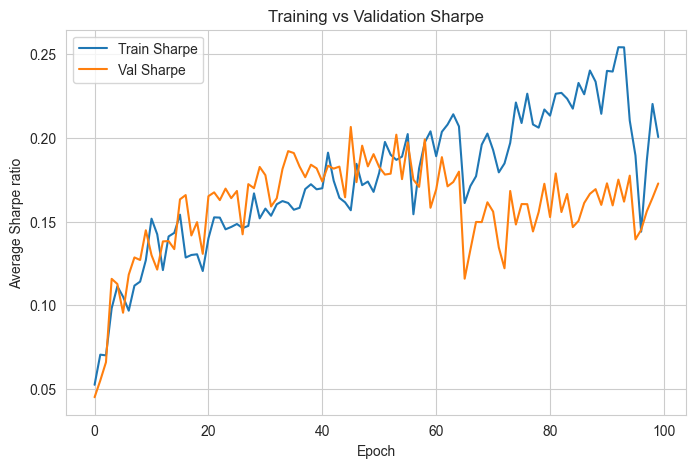

In [17]:
plt.figure(figsize=(8,5))
plt.plot(train_history, label="Train Sharpe")
plt.plot(val_history, label="Val Sharpe")
plt.xlabel("Epoch")
plt.ylabel("Average Sharpe ratio")
plt.title("Training vs Validation Sharpe")
plt.legend()
plt.grid(True)
plt.show()

### Validation Sharpe ratio:

In [18]:
model.eval()
all_weights, all_returns = [], []

with torch.no_grad():
    for X_batch, Y_batch in val_loader:
        w = model(X_batch)
        all_weights.append(w)
        all_returns.append(Y_batch)

In [19]:
# --- Concatenate weights and realized returns ---
W = torch.cat(all_weights).numpy()   # (T, 4) portfolio weights
R = torch.cat(all_returns).numpy()   # (T, 4) realized next-day asset returns
sp500_rets = R[:, 0]                 # S&P500 proxy: stock_return column

# --- Benchmark weights: 25% stocks, 75% bonds ---
bench_rets = 0.25 * R[:, 0] + 0.75 * R[:, 1]

# --- Portfolio daily returns ---
port_rets = (W * R).sum(axis=1)

# --- Cumulative growth ---
initial_capital = 100
cum_growth = (1 + port_rets).cumprod()
cum_sp500  = (1 + sp500_rets).cumprod()
cum_bench = (1 + bench_rets).cumprod()
final_value  = initial_capital * cum_growth[-1]
final_sp500  = initial_capital * cum_sp500[-1]
final_bench = initial_capital * cum_bench[-1]

# --- Time stats ---
n_days = len(port_rets)
n_years = n_days / 252  # assuming 252 trading days per year

# --- DAILY STATISTICS ---
port_mean_daily = port_rets.mean()
port_std_daily  = port_rets.std()
sp_mean_daily   = sp500_rets.mean()
sp_std_daily    = sp500_rets.std()
bench_mean_daily = bench_rets.mean()
bench_std_daily  = bench_rets.std()


# --- SHARPE RATIOS ---
port_sharpe_daily  = port_mean_daily / port_std_daily
sp500_sharpe_daily = sp_mean_daily / sp_std_daily
bench_sharpe_daily  = bench_mean_daily / bench_std_daily
port_sharpe_annual = port_sharpe_daily * np.sqrt(252)
sp500_sharpe_annual = sp500_sharpe_daily * np.sqrt(252)
bench_sharpe_annual = bench_sharpe_daily * np.sqrt(252)

# --- MAXIMUM DAILY LOSS ---
max_loss_port = port_rets.min()
max_loss_sp500 = sp500_rets.min()
max_loss_bench = bench_rets.min()

# --- DOWNSIDE DEVIATION (daily) ---
target_return = 0.0  # typically 0 or risk-free rate
downside_diff = np.minimum(0, port_rets - target_return)
port_downside_std = np.sqrt((downside_diff**2).mean())
downside_diff_sp = np.minimum(0, sp500_rets - target_return)
sp_downside_std = np.sqrt((downside_diff_sp**2).mean())
downside_diff_bench = np.minimum(0, bench_rets - target_return)
bench_downside_std = np.sqrt((downside_diff_bench**2).mean())

# --- SORTINO RATIOS (daily) ---
port_sortino_daily = port_mean_daily / port_downside_std
sp500_sortino_daily = sp_mean_daily / sp_downside_std
bench_sortino_daily = bench_mean_daily / bench_downside_std

# --- SORTINO RATIOS (annualized) ---
port_sortino_annual = port_sortino_daily * np.sqrt(252)
sp500_sortino_annual = sp500_sortino_daily * np.sqrt(252)
bench_sortino_annual = bench_sortino_daily * np.sqrt(252)

# --- PRINT RESULTS ---
print("\n=== Performance Summary in Validation Set===")
print(f"Initial investment:         ${initial_capital:.2f}")
print(f"Final portfolio value:      ${final_value:.2f}")
print(f"Final S&P 500 value:        ${final_sp500:.2f}")
print(f"Final Benchmark (75/25) value:     ${final_bench:.2f}")
print(f"Total trading days:         {n_days:,}  (~{n_years:.2f} years)")
print("--------------------------------------------------")
print(f"Portfolio Sharpe (daily):          {port_sharpe_daily:.4f}")
print(f"S&P 500 Sharpe (daily):            {sp500_sharpe_daily:.4f}")
print(f"Benchmark Sharpe (daily):          {bench_sharpe_daily:.4f}")
print("--------------------------------------------------")
print(f"Portfolio Sharpe (annual):         {port_sharpe_annual:.4f}")
print(f"S&P 500 Sharpe (annual):           {sp500_sharpe_annual:.4f}")
print(f"Benchmark Sharpe (annual):         {bench_sharpe_annual:.4f}")
print("--------------------------------------------------")
print(f"Portfolio Sortino (daily):         {port_sortino_daily:.4f}")
print(f"S&P 500 Sortino (daily):           {sp500_sortino_daily:.4f}")
print(f"Benchmark Sortino (daily):         {bench_sortino_daily:.4f}")
print("--------------------------------------------------")
print(f"Portfolio Sortino (annual):        {port_sortino_annual:.4f}")
print(f"S&P 500 Sortino (annual):          {sp500_sortino_annual:.4f}")
print(f"Benchmark Sortino (annual):        {bench_sortino_annual:.4f}")
print("--------------------------------------------------")
print(f"Max 1-day loss (Portfolio):        {max_loss_port*100:.2f}%")
print(f"Max 1-day loss (S&P 500):          {max_loss_sp500*100:.2f}%")
print(f"Max 1-day loss (Benchmark):        {max_loss_bench*100:.2f}%")
print("--------------------------------------------------")



=== Performance Summary in Validation Set===
Initial investment:         $100.00
Final portfolio value:      $348.68
Final S&P 500 value:        $173.38
Final Benchmark (75/25) value:     $129.99
Total trading days:         1,208  (~4.79 years)
--------------------------------------------------
Portfolio Sharpe (daily):          0.1625
S&P 500 Sharpe (daily):            0.0506
Benchmark Sharpe (daily):          0.0872
--------------------------------------------------
Portfolio Sharpe (annual):         2.5801
S&P 500 Sharpe (annual):           0.8037
Benchmark Sharpe (annual):         1.3849
--------------------------------------------------
Portfolio Sortino (daily):         0.2979
S&P 500 Sortino (daily):           0.0711
Benchmark Sortino (daily):         0.1277
--------------------------------------------------
Portfolio Sortino (annual):        4.7283
S&P 500 Sortino (annual):          1.1292
Benchmark Sortino (annual):        2.0279
----------------------------------------------

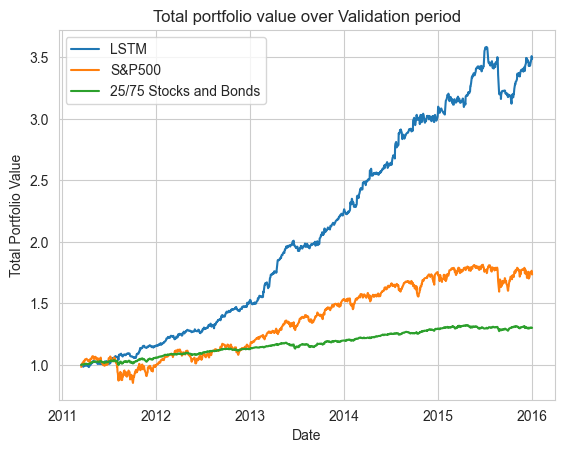

In [20]:
plt.plot(df_val['date'][seq_len:], cum_growth, label='LSTM')
plt.plot(df_val['date'][seq_len:], cum_sp500, label='S&P500')
plt.plot(df_val['date'][seq_len:], cum_bench, label='25/75 Stocks and Bonds')
plt.xlabel("Date")
plt.ylabel("Total Portfolio Value")
plt.title("Total portfolio value over Validation period")
plt.legend()
plt.grid(True)
plt.show()

### Test Sharpe ratio:

In [21]:
model.eval()
all_weights, all_returns = [], []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        w = model(X_batch)
        all_weights.append(w)
        all_returns.append(Y_batch)

In [22]:
# --- Concatenate weights and realized returns ---
W = torch.cat(all_weights).numpy()   # (T, 4) portfolio weights
R = torch.cat(all_returns).numpy()   # (T, 4) realized next-day asset returns
sp500_rets = R[:, 0]                 # S&P500 proxy: stock_return column

# --- Benchmark weights: 25% stocks, 75% bonds ---
w_stock = 0.25
w_bond  = 0.75
bench_rets = w_stock * R[:, 0] + w_bond * R[:, 1]

# --- Portfolio daily returns ---
port_rets = (W * R).sum(axis=1)

# --- Cumulative growth ---
initial_capital = 100
cum_growth = (1 + port_rets).cumprod()
cum_sp500  = (1 + sp500_rets).cumprod()
cum_bench = (1 + bench_rets).cumprod()
final_value  = initial_capital * cum_growth[-1]
final_sp500  = initial_capital * cum_sp500[-1]
final_bench = initial_capital * cum_bench[-1]

# --- Time stats ---
n_days = len(port_rets)
n_years = n_days / 252  # assuming 252 trading days per year

# --- DAILY STATISTICS ---
port_mean_daily = port_rets.mean()
port_std_daily  = port_rets.std()
sp_mean_daily   = sp500_rets.mean()
sp_std_daily    = sp500_rets.std()
bench_mean_daily = bench_rets.mean()
bench_std_daily  = bench_rets.std()

# --- SHARPE RATIOS ---
port_sharpe_daily  = port_mean_daily / port_std_daily
sp500_sharpe_daily = sp_mean_daily / sp_std_daily
bench_sharpe_daily  = bench_mean_daily / bench_std_daily
port_sharpe_annual = port_sharpe_daily * np.sqrt(252)
sp500_sharpe_annual = sp500_sharpe_daily * np.sqrt(252)
bench_sharpe_annual = bench_sharpe_daily * np.sqrt(252)

# --- MAXIMUM DAILY LOSS ---
max_loss_port = port_rets.min()
max_loss_sp500 = sp500_rets.min()
max_loss_bench = bench_rets.min()

# --- DOWNSIDE DEVIATION (daily) ---
target_return = 0.0  # typically 0 or risk-free rate
downside_diff = np.minimum(0, port_rets - target_return)
port_downside_std = np.sqrt((downside_diff**2).mean())
downside_diff_sp = np.minimum(0, sp500_rets - target_return)
sp_downside_std = np.sqrt((downside_diff_sp**2).mean())
downside_diff_bench = np.minimum(0, bench_rets - target_return)
bench_downside_std = np.sqrt((downside_diff_bench**2).mean())

# --- SORTINO RATIOS (daily) ---
port_sortino_daily = port_mean_daily / port_downside_std
sp500_sortino_daily = sp_mean_daily / sp_downside_std
bench_sortino_daily = bench_mean_daily / bench_downside_std

# --- SORTINO RATIOS (annualized) ---
port_sortino_annual = port_sortino_daily * np.sqrt(252)
sp500_sortino_annual = sp500_sortino_daily * np.sqrt(252)
bench_sortino_annual = bench_sortino_daily * np.sqrt(252)

# --- PRINT RESULTS ---
print("\n=== Performance Summary in Test Set===")
print(f"Initial investment:         ${initial_capital:.2f}")
print(f"Final portfolio value:      ${final_value:.2f}")
print(f"Final S&P 500 value:        ${final_sp500:.2f}")
print(f"Final Benchmark (75/25) value:     ${final_bench:.2f}")
print(f"Total trading days:         {n_days:,}  (~{n_years:.2f} years)")
print(f"Initial Date: {df_test['date'].min().strftime('%Y-%m-%d')}")
print(f"End Date: {df_test['date'].max().strftime('%Y-%m-%d')}")
print("--------------------------------------------------")
print(f"Portfolio Sharpe (daily):          {port_sharpe_daily:.4f}")
print(f"S&P 500 Sharpe (daily):            {sp500_sharpe_daily:.4f}")
print(f"Benchmark Sharpe (daily):          {bench_sharpe_daily:.4f}")
print("--------------------------------------------------")
print(f"Portfolio Sharpe (annual):         {port_sharpe_annual:.4f}")
print(f"S&P 500 Sharpe (annual):           {sp500_sharpe_annual:.4f}")
print(f"Benchmark Sharpe (annual):         {bench_sharpe_annual:.4f}")
print("--------------------------------------------------")
print(f"Portfolio Sortino (daily):         {port_sortino_daily:.4f}")
print(f"S&P 500 Sortino (daily):           {sp500_sortino_daily:.4f}")
print(f"Benchmark Sortino (daily):         {bench_sortino_daily:.4f}")
print("--------------------------------------------------")
print(f"Portfolio Sortino (annual):        {port_sortino_annual:.4f}")
print(f"S&P 500 Sortino (annual):          {sp500_sortino_annual:.4f}")
print(f"Benchmark Sortino (annual):        {bench_sortino_annual:.4f}")
print("--------------------------------------------------")
print(f"Max 1-day loss (Portfolio):        {max_loss_port*100:.2f}%")
print(f"Max 1-day loss (S&P 500):          {max_loss_sp500*100:.2f}%")
print(f"Max 1-day loss (Benchmark):        {max_loss_bench*100:.2f}%")
print("--------------------------------------------------")



=== Performance Summary in Test Set===
Initial investment:         $100.00
Final portfolio value:      $356.35
Final S&P 500 value:        $154.02
Final Benchmark (75/25) value:     $128.61
Total trading days:         1,039  (~4.12 years)
Initial Date: 2016-01-04
End Date: 2020-04-30
--------------------------------------------------
Portfolio Sharpe (daily):          0.1557
S&P 500 Sharpe (daily):            0.0406
Benchmark Sharpe (daily):          0.0646
--------------------------------------------------
Portfolio Sharpe (annual):         2.4720
S&P 500 Sharpe (annual):           0.6448
Benchmark Sharpe (annual):         1.0249
--------------------------------------------------
Portfolio Sortino (daily):         0.2754
S&P 500 Sortino (daily):           0.0555
Benchmark Sortino (daily):         0.0857
--------------------------------------------------
Portfolio Sortino (annual):        4.3715
S&P 500 Sortino (annual):          0.8818
Benchmark Sortino (annual):        1.3599
------

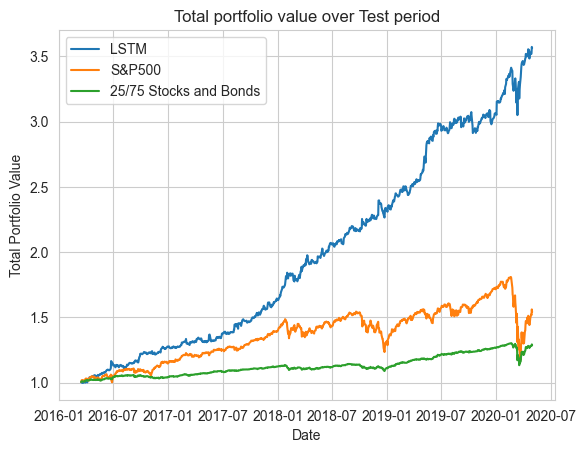

In [23]:
plt.plot(df_test['date'][seq_len:], cum_growth, label='LSTM')
plt.plot(df_test['date'][seq_len:], cum_sp500, label='S&P500')
plt.plot(df_test['date'][seq_len:], cum_bench, label='25/75 Stocks and Bonds')
plt.xlabel("Date")
plt.ylabel("Total Portfolio Value")
plt.title("Total portfolio value over Test period")
plt.legend()
plt.grid(True)
plt.show()


### Adding transaction costs: 

In [24]:
# --- Transaction Cost Parameters ---
C = 0.001   # 1 bp per turnover, adjust as desired (e.g., 0.001 = 10 bps)

# --- Compute daily turnover ---
turnover = np.abs(W[1:] - W[:-1]).sum(axis=1)

# --- Compute transaction cost per day ---
cost = C * turnover

# --- Compute net returns (subtract cost from daily return) ---
# skip the first day because there’s no previous weight for turnover
port_rets_net = port_rets[1:] - cost

# --- DAILY STATISTICS (after transaction costs) ---
port_mean_daily_net = port_rets_net.mean()
port_std_daily_net  = port_rets_net.std()

# --- SHARPE RATIOS (after transaction costs) ---
port_sharpe_daily_net  = port_mean_daily_net / port_std_daily_net
port_sharpe_annual_net = port_sharpe_daily_net * np.sqrt(252)

# --- Cumulative growth with transaction costs ---
initial_capital = 100
cum_growth_net = (1 + port_rets_net).cumprod()
final_value_net = initial_capital * cum_growth_net[-1]

print(f"Final portfolio value (after costs): ${final_value_net:.2f}")
print(f"Adjusted Sharpe ratio: {port_sharpe_annual_net:.2f}")
print(f"Average daily turnover: {turnover.mean():.4f}")
print(f"Average daily transaction cost: {(cost.mean()*100):.4f}%")

Final portfolio value (after costs): $288.08
Adjusted Sharpe ratio: 2.07
Average daily turnover: 0.2032
Average daily transaction cost: 0.0203%


### To do list:

1. Quantify the effect of `shuffle=False` vs `shuffle=True` during training.
2. Add the risk free rate to the analysis.
3. Depart the fixed-epoch training approach. 
    3.1. Early stopping.
    3.2. Learning rate scheduling.
4. Expanding window training, perform rolling-window backtest. Test how robust the approach is over time.
5. Improve Hyperparameter tunning by using Bayesian optimization (Optuna).
6. Work on CUDA implementation.